In [240]:
import logging
import os
import sys
import warnings
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as sc_sts
import mlxtend

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

%matplotlib inline

In [17]:
## Some display settings
pd.set_option('display.max_rows',105)
pd.set_option('display.max_columns',50)
warnings.filterwarnings(category=FutureWarning,action='ignore')

In [3]:
## Visualization Global Variables
label_dict = {'family':'Calibri','size':21,'style':'oblique','color':'coral'}
title_dict = {'family':'Calibri','size':23,'style':'oblique','color':'magenta'}
wedge_dict = {'linewidth': 1, 'edgecolor': 'black'}
txt_dict = {'family':'Calibri','size':16,'style':'oblique','color':'k'}

In [25]:
cer_cancer_df = pd.read_csv('Datasets/Cervical_cancer/kag_risk_factors_cervical_cancer.csv').rename(columns={'Citology':'Cytology'})

In [26]:
cer_cancer_df['Updt_Dx'] = cer_cancer_df[['Dx:Cancer','Dx']].apply(lambda row: 1 if row['Dx:Cancer'] == 1 and row['Dx'] == 0 else row['Dx'],\
                                                                   axis=1)

In [27]:
cer_cancer_df.drop(['STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'],axis=1,inplace=True)

In [37]:
cer_cancer_df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Hinselmann', 'Schiller', 'Cytology',
       'Biopsy', 'Updt_Dx'],
      dtype='object')

#### **Filling missing values**
- *'Hormonal Contraceptives'*
- *'Hormonal Contraceptives (years)'*
- *'IUD'*
- *'IUD (years)'*
- *'STDs'*
- *'STDs (number)'*
- *'STDs:condylomatosis'*
- *'STDs:cervical condylomatosis'*
- *'STDs:vaginal condylomatosis'*
- *'STDs:vulvo-perineal condylomatosis'*
- *'STDs:syphilis'*
- *'STDs:pelvic inflammatory disease'*
- *'STDs:genital herpes'*
- *'STDs:molluscum contagiosum'*
- *'STDs:AIDS'*
- *'STDs:HIV'*
- *'STDs:Hepatitis B'*
- *'STDs:HPV'*

#### **For the above columns if 'Hormonal Contraceptives','STDs', 'IUD' and their corresponding features containing missing values then they all are imputed as -1.**
- The reason for imputing -1 is that these features are important in terms of prediction thus if patient doesn't provide these details then not even the doctor can tell whether the patient is positive or not in the screening. Hence, I thought this would be best way to make the model learn such kind of data with a different manner.
    - I'm applying this implementation on the entire dataset then will create a separate TRAIN and TEST splits. This will introduce any data leakage as I'm filling an all together different value irrespective of the dataset. And, this has be to be implemented in the both the sets.

In [73]:
cer_cancer_df[['Hormonal Contraceptives','STDs','IUD','STDs:cervical condylomatosis']].\
apply(lambda row: -1 if row['STDs']=='?' and row['Hormonal Contraceptives']=='?' and row['IUD']=='?' else row['STDs:cervical condylomatosis']\
      ,axis=1).value_counts()

0.0    753
-1      95
?       10
dtype: int64

In [72]:
# cer_cancer_df['STDs:cervical condylomatosis'] = cer_cancer_df[['Hormonal Contraceptives','STDs','IUD','STDs:cervical condylomatosis']].\
# apply(lambda row: -1 if row['STDs']==-1 and row['Hormonal Contraceptives']==-1 and row['IUD']==-1 else row['STDs:cervical condylomatosis']\
#      ,axis=1)

##### **I have performed the above implementation manually, later on will create a function of it.**

In [68]:
def compute_null_percentage(data_df):
    """
    Description: This function is created for calculating the NULL values percentage in every feature.
    
    Input: It accepts below parameters:
        - `data_df: pandas dataframe`
                Dataframe with entire dataset
    
    Return: It returns below object:
        -  `nulls_info_df: pandas dataframe`
                Dataframe containing nulls percentage feature-wise.    
    """
    cols = []
    null_percentage = []

    for col in data_df.columns:
        no_of_nulls = data_df[data_df[col] == '?'].shape[0]
        tot_rec = data_df.shape[0]
        nulls_percent = np.round((np.divide(no_of_nulls,tot_rec,dtype= np.float) * 100),2)
        cols.append(col)
        null_percentage.append(nulls_percent)
    
    nulls_info_df = pd.DataFrame({'Feature_Name':cols,'NULL Percentage':null_percentage})
    return nulls_info_df

In [74]:
nulls_percentage_df = compute_null_percentage(data_df=cer_cancer_df)

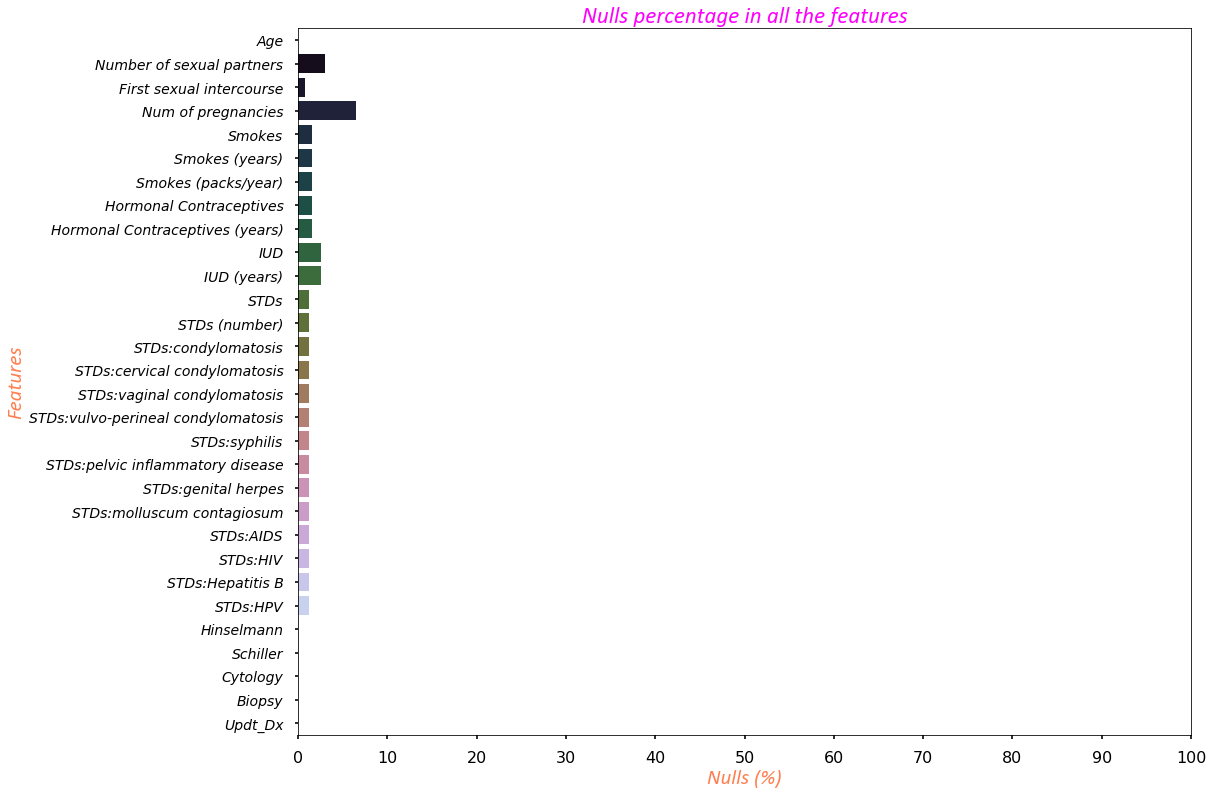

In [75]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,13))
    sns.barplot(y='Feature_Name',x='NULL Percentage',data=nulls_percentage_df,palette='cubehelix')
    plt.xlabel('Nulls (%)',fontdict=label_dict)
    plt.ylabel('Features',fontdict=label_dict)
    plt.title('Nulls percentage in all the features',fontdict=title_dict)
    plt.xticks(np.arange(0,101,10))
    plt.yticks(size=14,rotation=0,style='italic',color='k')

### ***`First, I'm taking trying to build a model that can predict whether patient should undergo Biopsy or not?`***

In [83]:
cer_cancer_df.drop(['Hinselmann', 'Schiller', 'Cytology'],axis=1,inplace=True)

In [116]:
cer_cancer_df.to_csv('CC_Before_train_test_split.csv',index=False)

In [295]:
cer_cancer_df = pd.read_csv("CC_Before_train_test_split.csv")

In [296]:
cer_cancer_df['Biopsy'].value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [297]:
X = cer_cancer_df[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV','Updt_Dx']]

X.shape

(858, 26)

In [298]:
y = cer_cancer_df[['Biopsy']]

y.shape

(858, 1)

#### **Separating data into TRAIN and TEST sets**

In [335]:
X1, X_test, y1, y_test = train_test_split(X,y,test_size=0.40,stratify=y,random_state=24)

In [336]:
print(X1.shape,y1.shape,X_test.shape,y_test.shape)

(514, 26) (514, 1) (344, 26) (344, 1)


In [337]:
y1.value_counts()

Biopsy
0         481
1          33
dtype: int64

In [338]:
y_test.value_counts()

Biopsy
0         322
1          22
dtype: int64

### **Checking whether TRAIN and TEST are from same distribution**
- *This is an important step because if Train and Test doesn't belongs to the same distribution then it means both the datasets are coming from different populations and are totally separable which is not the right thing.*

##### **Dropping the diagnosis feature from both the sets as this column won't be available in real-time**

In [339]:
X1 = X1.drop(['Updt_Dx'],axis=1)
X_test = X_test.drop(['Updt_Dx'],axis=1)

##### **Creating new `train1` and `test1` sets from `TRAIN` and `TEST`**

##### **TRAIN1**

In [340]:
X1 = X1.applymap(lambda val: np.NaN if val =='?' else np.float(val))

In [345]:
X1.shape

(514, 24)

In [346]:
y1.shape

(514, 1)

In [343]:
ss = StandardScaler()

In [357]:
X1 = pd.DataFrame(ss.fit_transform(X1.iloc[:,0:-1]),columns=X1.columns[0:-1]).reset_index(drop=True)
X1.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV
0,-0.229913,-0.293250,1.035909,-0.849805,-0.423659,-0.295996,-0.194439,0.797724,0.186753,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738
1,-0.000223,1.842978,0.682554,0.483821,-0.423659,-0.295996,-0.194439,-0.638179,-0.519121,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738
2,-0.000223,1.308921,0.682554,-0.182992,-0.423659,-0.295996,-0.194439,0.797724,0.327928,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738
3,1.377912,-0.293250,-0.024155,1.150633,-0.423659,-0.295996,-0.194439,0.797724,-0.236772,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738
4,-0.344757,-0.293250,0.329200,-0.849805,-0.423659,-0.295996,-0.194439,0.797724,0.892627,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738


In [360]:
train1 = pd.concat([X1.iloc[:,:],y1.iloc[:,:].reset_index(drop=True)],axis=1)

In [361]:
train1['target'] = 1   ## Added a new dummy target with value as 1

In [362]:
train1.shape

(514, 25)

In [363]:
train1.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,Biopsy,target
0,-0.229913,-0.293250,1.035909,-0.849805,-0.423659,-0.295996,-0.194439,0.797724,0.186753,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738,0,1
1,-0.000223,1.842978,0.682554,0.483821,-0.423659,-0.295996,-0.194439,-0.638179,-0.519121,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738,0,1
2,-0.000223,1.308921,0.682554,-0.182992,-0.423659,-0.295996,-0.194439,0.797724,0.327928,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738,0,1
3,1.377912,-0.293250,-0.024155,1.150633,-0.423659,-0.295996,-0.194439,0.797724,-0.236772,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738,0,1
4,-0.344757,-0.293250,0.329200,-0.849805,-0.423659,-0.295996,-0.194439,0.797724,0.892627,0.042722,-0.17431,0.024891,-0.089906,0.135851,0.365148,0.326023,0.141421,0.274411,0.354952,0.354952,0.365148,0.365148,0.258738,0,1


##### **TEST1**

In [364]:
X_test = X_test.applymap(lambda val: np.NaN if val =='?' else np.float(val))
y_test = y_test.applymap(lambda val: np.int(val))

In [368]:
ss_t = StandardScaler()

In [372]:
ss_t.mean_ = ss.mean_
ss_t.var_ = ss.var_
ss_t.scale_ = ss.scale_

In [ ]:
ss.scale_()

In [375]:
ss_t.fit_transform(X_test.iloc[:,0:-1])

array([[-1.41630659,  1.15888421, -1.77329778, ...,  0.3398699 ,
         0.25418068,  0.3398699 ],
       [ 1.52681629, -1.15194479,  2.58284677, ...,  0.3398699 ,
         0.25418068,  0.3398699 ],
       [ 0.05525485, -1.15194479,  0.04176245, ...,  0.3398699 ,
         0.25418068,  0.3398699 ],
       ...,
       [ 0.17788497, -0.38166845, -0.68426164, ...,  0.3398699 ,
         0.25418068,  0.3398699 ],
       [-1.17104635, -0.38166845, -0.68426164, ...,  0.3398699 ,
         0.25418068,  0.3398699 ],
       [ 0.79103557, -1.15194479,  5.48694314, ...,  0.3398699 ,
         0.25418068,  0.3398699 ]])

In [378]:
ss_t.mean_[1] == ss.mean_[1]

False

In [210]:
test1 = pd.concat([X_test,y_test],axis=1)

In [211]:
test1['target'] = 0

In [212]:
test1.shape

(344, 27)

In [213]:
test1.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Biopsy,target
554,15.0,4.0,12.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
38,39.0,1.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
11,27.0,1.0,17.0,3.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
501,32.0,1.0,22.0,2.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
375,22.0,1.0,16.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


##### **Imputing Missing Values in `train1` and `test1` using KNN Imputer**

In [203]:
knn_imputer = KNNImputer(n_neighbors=7,weights='distance')

In [204]:
train1_missing_removed = pd.DataFrame(knn_imputer.fit_transform(train1),columns=train1.columns)

In [214]:
test1_missing_removed = pd.DataFrame(knn_imputer.fit_transform(test1),columns=test1.columns)

##### **Model training on `train1` and testing on `test1`**

In [206]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=7)

In [217]:
dt_model = dt.fit(train1_missing_removed.iloc[:,0:-1],train1_missing_removed['target'])

In [218]:
knn_model = knn.fit(train1_missing_removed.iloc[:,0:-1],train1_missing_removed['target'])

##### **Decision Tree :: Results**

In [219]:
y_pred = dt_model.predict(test1_missing_removed.iloc[:,0:-1])

In [220]:
accuracy_score(y_pred,y_test), precision_score(y_pred,y_test), recall_score(y_pred,y_test)

(0.06395348837209303, 1.0, 0.06395348837209303)

In [221]:
confusion_matrix(y_pred,y_test)

array([[  0,   0],
       [322,  22]], dtype=int64)

In [225]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

##### **KNN :: Results**

In [222]:
y_pred_knn = knn_model.predict(test1_missing_removed.iloc[:,0:-1])

In [223]:
accuracy_score(y_pred_knn,y_test['Biopsy']), precision_score(y_pred_knn,y_test['Biopsy']), recall_score(y_pred_knn,y_test['Biopsy'])

(0.06395348837209303, 1.0, 0.06395348837209303)

In [224]:
confusion_matrix(y_pred_knn,y_test)

array([[  0,   0],
       [322,  22]], dtype=int64)

In [226]:
y_pred_knn

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

#### **The above results are saying that both TRAIN and TEST sets are entirely similar and not separable. Thus, we are good to go ahead.**

## **`Filling_Missing_Values`**
##### *Here, I'll work on imputing the missing values in TRAIN set.*

In [238]:
nulls_percentage_df = compute_null_percentage(data_df=X1)

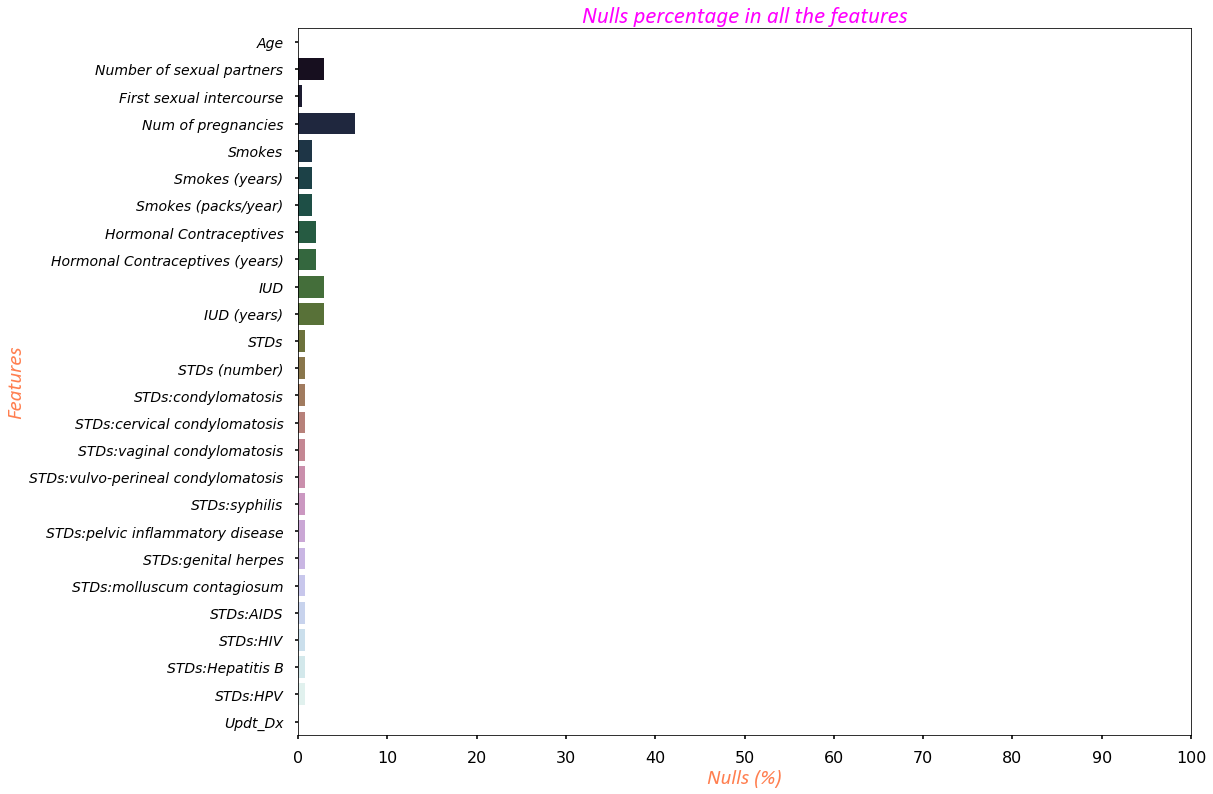

In [239]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,13))
    sns.barplot(y='Feature_Name',x='NULL Percentage',data=nulls_percentage_df,palette='cubehelix')
    plt.xlabel('Nulls (%)',fontdict=label_dict)
    plt.ylabel('Features',fontdict=label_dict)
    plt.title('Nulls percentage in all the features',fontdict=title_dict)
    plt.xticks(np.arange(0,101,10))
    plt.yticks(size=14,rotation=0,style='italic',color='k')

In [109]:
X1['Number of sexual partners']

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Updt_Dx
834,30,3.0,15.0,0.0,1.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
799,19,3.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
658,18,2.0,14.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
54,36,1.0,16.0,3.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
310,23,2.0,18.0,1.0,0.0,0.0,0.0,1.0,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,34,3.0,19.0,3.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
653,21,1.0,17.0,?,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
68,35,3.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
640,32,4.0,18.0,3.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
cer_cancer_df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Hinselmann', 'Schiller', 'Cytology',
       'Biopsy', 'Updt_Dx'],
      dtype='object')